In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
res_1_df = pd.read_csv('results_1.1.csv')

In [3]:
res_1_df.head()

,degree,threads,time_alloc,time_init,time_seq_baseline,time_thread_create,time_compute,time_thread_join,time_cleanup,time_total,user
0,5000,sequential,0.000022,0.001611,0.012571,0.000000,0.000000,0.000000,0.000001,0.014205,marr
1,5000,1,0.000030,0.000271,0.000000,0.000058,0.010114,0.000006,0.000001,0.010481,marr
2,5000,2,0.000031,0.000121,0.000000,0.000102,0.003396,0.000010,0.000000,0.003660,marr
3,5000,4,0.000055,0.000122,0.000000,0.000238,0.006157,0.000024,0.000001,0.006597,marr
4,5000,8,0.000083,0.000144,0.000000,0.000476,0.006392,0.000035,0.000001,0.007131,marr


In [4]:
os.makedirs('plots', exist_ok=True)

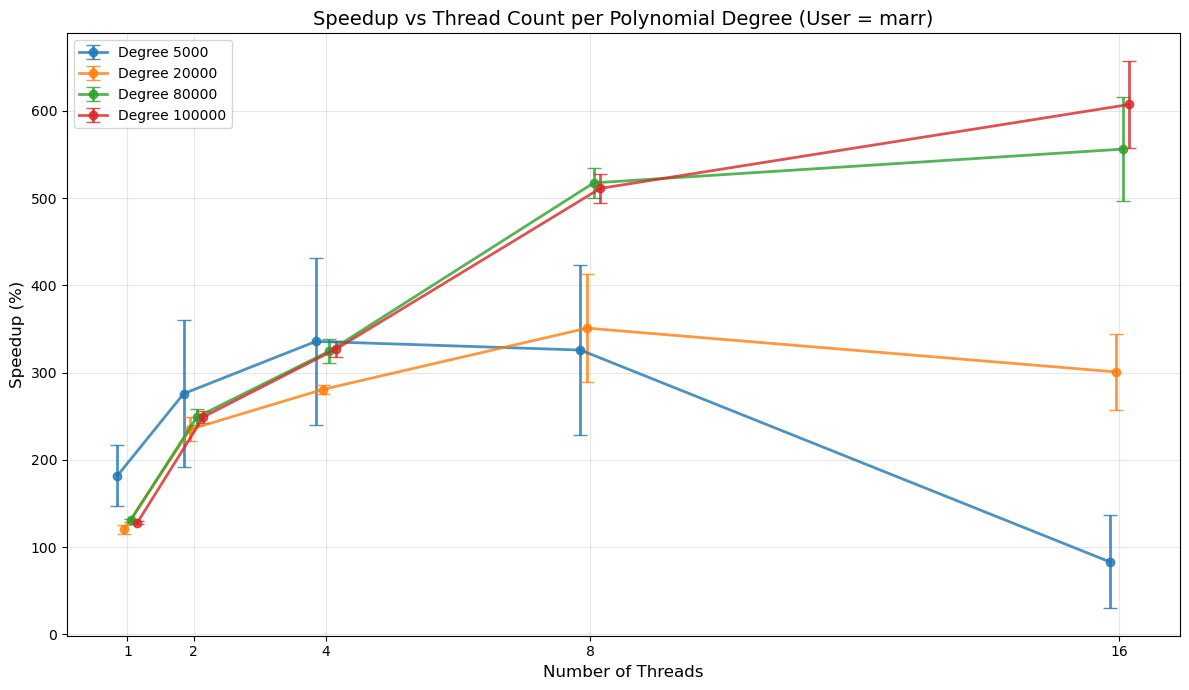

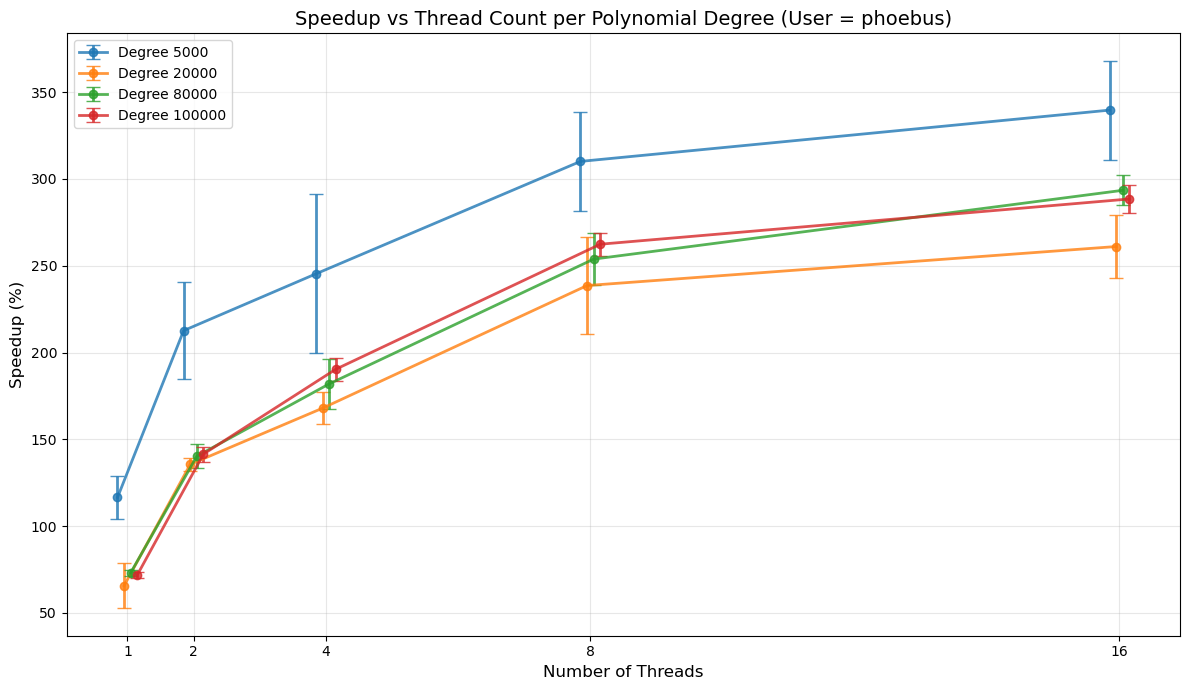

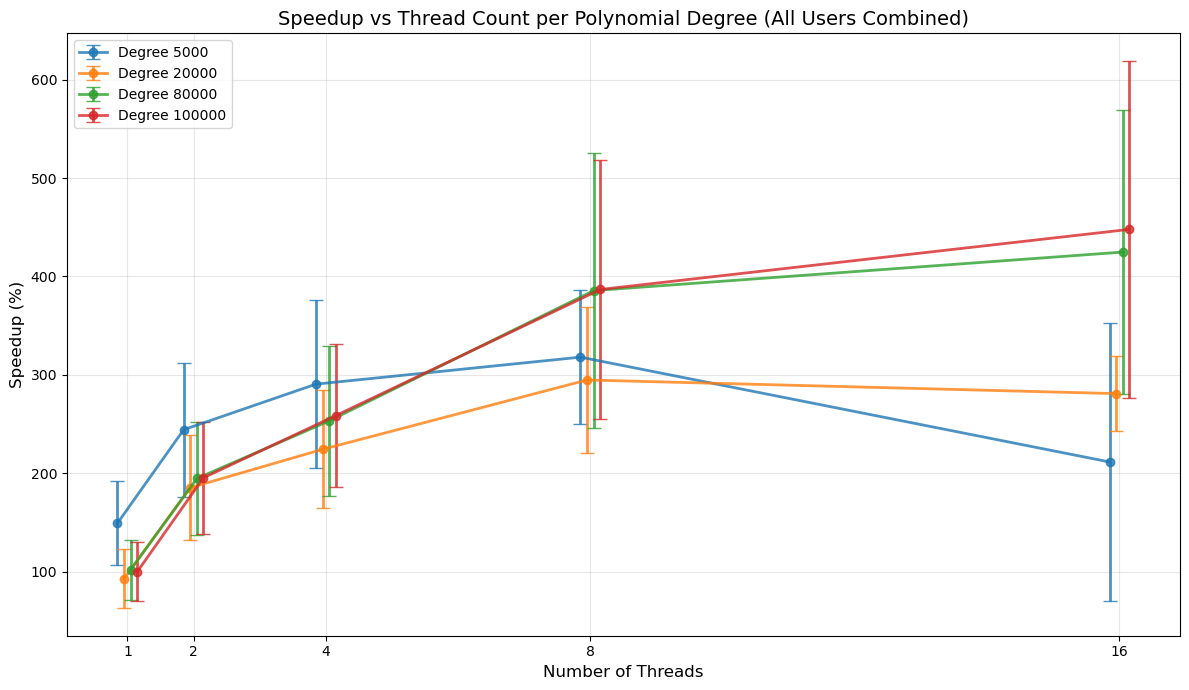


Combined Statistics (Mean ± Std %):
 degree  threads   mean_pct    std_pct
   5000        1 149.271936  42.591542
   5000        2 244.263434  68.049586
   5000        4 290.575691  85.210578
   5000        8 318.022061  67.836068
   5000       16 211.477082 141.032553
  20000        1  92.955871  30.266923
  20000        2 185.321895  53.296058
  20000        4 224.302146  59.849578
  20000        8 294.810198  74.682019
  20000       16 280.951339  38.074552
  80000        1 102.060184  30.545802
  80000        2 194.689417  57.863239
  80000        4 253.207999  76.302273
  80000        8 385.642902 139.764914
  80000       16 424.824230 144.214700
 100000        1  99.992672  29.668856
 100000        2 195.419836  57.101846
 100000        4 258.600189  72.341125
 100000        8 386.782716 131.632903
 100000       16 447.914262 171.419109

Unique users: ['marr', 'phoebus']
Plots saved for each user and combined plot.


In [5]:
# Calculate speedup (sequential time / parallel time)
speedup_data = []

for degree in res_1_df['degree'].unique():
    degree_data = res_1_df[res_1_df['degree'] == degree]
    seq_time = degree_data[degree_data['threads'] == 'sequential']['time_total'].values
    
    if len(seq_time) > 0:
        seq_time = seq_time[0]
        for _, row in degree_data[degree_data['threads'] != 'sequential'].iterrows():
            speedup = seq_time / row['time_total']
            speedup_data.append({
                'degree': degree,
                'threads': int(row['threads']),
                'speedup': speedup,
                'user': row['user']
            })

speedup_df = pd.DataFrame(speedup_data)

# Get unique users
unique_users = speedup_df['user'].unique()

# Create plots for each user
for user in unique_users:
    user_data = speedup_df[speedup_df['user'] == user]
    speedup_stats = user_data.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()
    
    # Convert to percentage
    speedup_stats['mean_pct'] = speedup_stats['mean'] * 100
    speedup_stats['std_pct'] = speedup_stats['std'] * 100
    
    # Plot speedup with error bars and jitter
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define jitter offset for each degree
    unique_degrees = sorted(speedup_stats['degree'].unique())
    jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))
    
    for idx, degree in enumerate(unique_degrees):
        degree_stats = speedup_stats[speedup_stats['degree'] == degree].copy()
        # Add jitter to x positions
        x_jitter = degree_stats['threads'] + jitter_offset[idx]
        ax.errorbar(x_jitter, degree_stats['mean_pct'], 
                    yerr=degree_stats['std_pct'], marker='o', label=f'Degree {int(degree)}', 
                    linewidth=2, capsize=5, linestyle='-', alpha=0.8)
    
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel('Speedup (%)', fontsize=12)
    ax.set_title(f'Speedup vs Thread Count per Polynomial Degree (User = {user})', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(speedup_stats['threads'].unique()))
    
    plt.tight_layout()
    plt.savefig(f'plots/speedup_per_degree_{user}.png', dpi=300)
    plt.show()

# Create combined plot with all users - calculate mean and std across all users
if len(unique_users) > 1:
    speedup_stats_all = speedup_df.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()
    
    # Convert to percentage
    speedup_stats_all['mean_pct'] = speedup_stats_all['mean'] * 100
    speedup_stats_all['std_pct'] = speedup_stats_all['std'] * 100
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    unique_degrees = sorted(speedup_stats_all['degree'].unique())
    jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))
    
    for idx, degree in enumerate(unique_degrees):
        degree_stats = speedup_stats_all[speedup_stats_all['degree'] == degree].copy()
        x_jitter = degree_stats['threads'] + jitter_offset[idx]
        ax.errorbar(x_jitter, degree_stats['mean_pct'], 
                    yerr=degree_stats['std_pct'], marker='o', label=f'Degree {int(degree)}', 
                    linewidth=2, capsize=5, linestyle='-', alpha=0.8)
    
    ax.set_xlabel('Number of Threads', fontsize=12)
    ax.set_ylabel('Speedup (%)', fontsize=12)
    ax.set_title('Speedup vs Thread Count per Polynomial Degree (All Users Combined)', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(sorted(speedup_stats_all['threads'].unique()))
    
    plt.tight_layout()
    plt.savefig('plots/speedup_per_degree_all_users.png', dpi=300)
    plt.show()
    
    print("\nCombined Statistics (Mean ± Std %):")
    print(speedup_stats_all[['degree', 'threads', 'mean_pct', 'std_pct']].to_string(index=False))

print(f"\nUnique users: {list(unique_users)}")
print(f"Plots saved for each user and combined plot.")
